# Машинное обучение
## Лабораторная работа №3

Выполнил студент группы 15-В-2   
Гончаренко Георгий
Вариант №9

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import (cross_val_score, StratifiedKFold,
                                     train_test_split)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from scipy.stats import pearsonr, spearmanr

from scipy.stats import pearsonr, spearmanr
sns.set_style("whitegrid")


### 1) Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).


| Переменная   | Описание  | Параметр  | 
|--------------|--------------|-------------------|
|mpg       |потребление топлива  | вещественный|
|cylinders| число цилиндров|дискретный|
|displacement|литраж|вещественный|
|horsepower|мощность|вещественный|
|weight|вес|вещественный|
|acceleration|ускорение|вещественный|
|model year|год выпуска|дискретный|
|origin|место производства|дискретный|
|car name|название модели|строка(уникальная)|


Уберем столбец car name из датасета, так как он не пригодится при решении задачи регрессии.
Будем предсказывать потребление топлива

In [2]:
df = pd.read_csv('auto_mpg.data.txt', sep=',')
df.drop('car name', axis=1, inplace=True)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [3]:
print('dataset size: ', df.shape)
df.count()

dataset size:  (398, 8)


mpg             398
cylinders       398
displacement    398
horsepower      392
weight          398
acceleration    398
model year      398
origin          398
dtype: int64

### 2) Удалите дубликаты строк в наборе данных; приведите размер набора данных до и после данной операции

In [4]:
df = df.drop_duplicates()
df = df.dropna().reset_index(drop=True)
print('dataset size: ', df.shape)

dataset size:  (392, 8)


### 3) Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию)

In [5]:
df['cylinders'] = df['cylinders'].apply(lambda x: str(x))
df['origin'] = df['origin'].apply(lambda x: str(x))
numerical_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns if df[i].dtype.name == 'object']

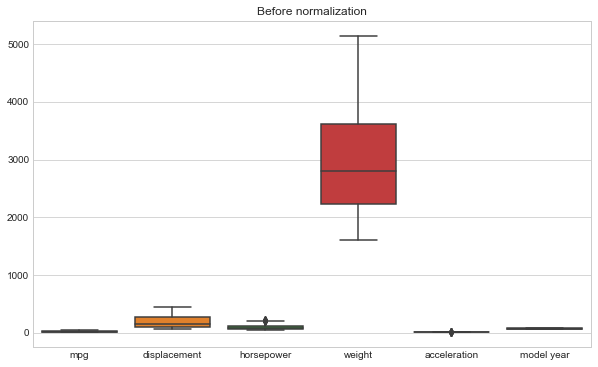

In [6]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df[numerical_columns])
plt.title("Before normalization")
plt.show()

In [7]:
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,0.239362,8,0.617571,0.456522,0.536150,0.238095,0.0,1
1,0.159574,8,0.728682,0.646739,0.589736,0.208333,0.0,1
2,0.239362,8,0.645995,0.565217,0.516870,0.178571,0.0,1
3,0.186170,8,0.609819,0.565217,0.516019,0.238095,0.0,1
4,0.212766,8,0.604651,0.510870,0.520556,0.148810,0.0,1


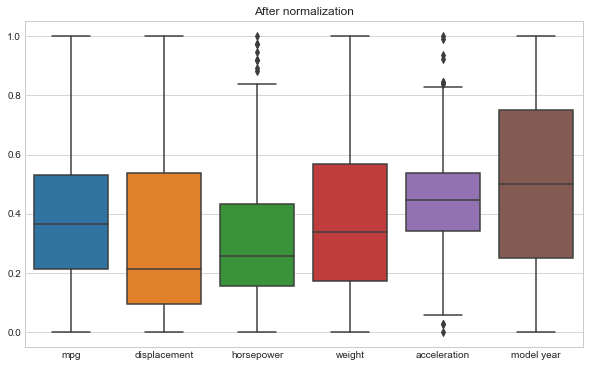

In [8]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df[numerical_columns])
plt.title("After normalization")
plt.show()

### 4)	Выполните замену категориальных признаков; выберите и обоснуйте способ замены

In [9]:
#Уникальных значений  мало, поэтмому применили dummy-кодирование
for i in categorial_columns:
    print(i,': ', df[i].unique())
    
df_categorial = pd.get_dummies(df[categorial_columns])
df.drop(categorial_columns, axis=1, inplace=True)
df = pd.concat([df_categorial, df] , axis=1)
print(df.shape)
df.head()

cylinders :  ['8' '4' '6' '3' '5']
origin :  ['1' '3' '2']
(392, 14)


,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,origin_1,origin_2,origin_3,mpg,displacement,horsepower,weight,acceleration,model year
0,0,0,0,0,1,1,0,0,0.239362,0.617571,0.456522,0.536150,0.238095,0.0
1,0,0,0,0,1,1,0,0,0.159574,0.728682,0.646739,0.589736,0.208333,0.0
2,0,0,0,0,1,1,0,0,0.239362,0.645995,0.565217,0.516870,0.178571,0.0
3,0,0,0,0,1,1,0,0,0.186170,0.609819,0.565217,0.516019,0.238095,0.0
4,0,0,0,0,1,1,0,0,0.212766,0.604651,0.510870,0.520556,0.148810,0.0


### 5) Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других

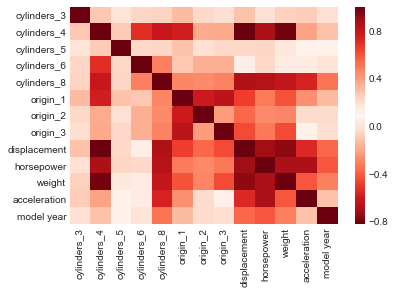

In [10]:
df_corr = df.drop('mpg', axis=1).corr()
colors = sns.color_palette("Reds_r", n_colors=100)
colors += sns.color_palette("Reds", n_colors=100)
sns.heatmap(df_corr, cmap=colors)
plt.show()

In [11]:
df.drop('horsepower', axis=1, inplace=True)

### 6) Заполните пропущенные значения в данных

In [12]:
print('dataset size: ', df.shape)
df.count()

dataset size:  (392, 13)


cylinders_3     392
cylinders_4     392
cylinders_5     392
cylinders_6     392
cylinders_8     392
origin_1        392
origin_2        392
origin_3        392
mpg             392
displacement    392
weight          392
acceleration    392
model year      392
dtype: int64

### 7)	Решите поставленную задачу регрессии в соответствии с заданием
 * Линейная регрессия без использования регуляризаторов
 * Линейная регрессия, Lasso регуляризатор

In [13]:
X, y = df.drop(['mpg' ], axis=1), df['mpg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)
reg = linear_model.Lasso (alpha = 0.1)
reg.fit (X_train, y_train)
xt = reg.predict(X_test)

In [14]:
reg.coef_

In [15]:
print(xt[:10]-y_test[:10])

220    0.179560
245   -0.416185
134    0.206156
147   -0.006610
390   -0.112993
33     0.206156
266   -0.091716
226    0.139666
263    0.166262
327   -0.554482
Name: mpg, dtype: float64


In [16]:
reg.intercept_

0.39232605994719677

In [17]:
X, y = df.drop(['mpg'], axis=1), df['mpg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)
reg = linear_model.LinearRegression()
reg.fit(X_train,y_train)
xt = reg.predict(X_test)

In [18]:
reg.coef_

array([  1.12281024e+12,   1.12281024e+12,   1.12281024e+12,
         1.12281024e+12,   1.12281024e+12,   1.25697385e+12,
         1.25697385e+12,   1.25697385e+12,   9.09423828e-02,
        -5.67504883e-01,   7.03125000e-02,   2.56835938e-01])

In [19]:
reg.intercept_

-2379784086149.0024

In [20]:
print(xt[:10]-y_test[:10])

220    0.027468
245   -0.186440
134   -0.034315
147    0.062978
390    0.062552
33    -0.050916
266    0.093106
226    0.017848
263    0.023936
327   -0.265168
Name: mpg, dtype: float64


In [21]:
corr={}
corr['pearson'], _ = pearsonr(xt,y_test)
corr['spearman'], _ = spearmanr(xt,y_test)
print(corr['pearson'])
print(corr['spearman'])

0.873705454698
0.905148185575
